# This is a quick explainer notebook to show how I use basis function expansions to go from images of galaxies to sounds. I use the Mingus and Fluidsynth python packages to do all of the sound-related bits, and code shamelessly copied from Mike to do the 2D basis function expansions. 

Link to Mingus documentation: https://bspaans.github.io/python-mingus/index.html

Link to Fluidsynth documentation: https://github.com/FluidSynth/fluidsynth/wiki

I use Mingus to create notes and MIDI information/events. MIDI basically just gives the computer the instructions to play music (like which notes in what order and on what instrument), but a synthesizer is needed to actually make the sound. I use Fluidsynth as my synthesizer. The last piece is a soundfont file, which provides the sound clips for a bunch of instruments that the synthesizer can then play. 

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
from mike_code import LaguerreAmplitudes
import matplotlib.cm as cm
from skimage.transform import resize_local_mean

In [22]:
from mingus.containers import NoteContainer, Note, Bar
import mingus.core.notes as notes
import mingus.core.keys as keys
from mingus.midi import fluidsynth
from mingus.containers import Composition
from mingus.containers import Track
from mingus.containers.instrument import MidiInstrument
import time
#need to initialize fluidsynth with our soundfont - this just tells fluidsynth where our sounds live
fluidsynth.init("/Users/caf/Developer/sonify/env/GeneralUser GS 1.471/soundfont.sf2",'coreaudio')
#coreaudio, file, portaudio seem to be only viable options
#possible drivers:  ‘alsa’, ‘oss’, ‘jack’, ‘portaudio’, ‘sndmgr’, ‘coreaudio’, ‘Direct Sound’, ‘dsound’, ‘pulseaudio’

True

### quick test of audio output - 

In [23]:
fluidsynth.set_instrument(1,1)
fluidsynth.play_Note(Note('A'), channel=1)
time.sleep(2)
fluidsynth.stop_Note(Note('A'),channel=1)

True

## Start with loading in some images of SDSS galaxies taken from Google 

(319, 319) (307, 307)


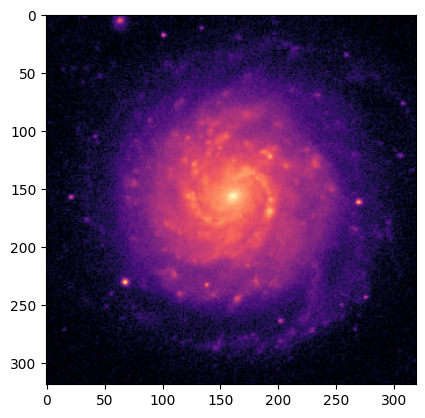

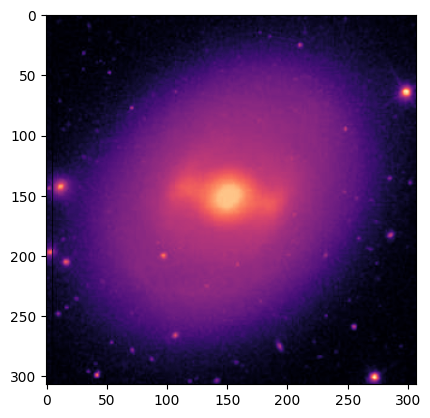

In [24]:
spiralf = np.asarray(Image.open('spiral.jpeg'))
spiralf = np.mean(spiralf,axis=2)/np.max(spiralf) #combining color chanels + normalizing range from 0 to 1
spiralf = spiralf[1:,1:] #slightly scootching over to center better

barf = np.asarray(Image.open('ngc936.jpg'))
barf = np.mean(barf, axis=2)
barf = barf/barf.max()
barf = barf[13:, 13:] #slightly scootching over to center better

print(spiralf.shape, barf.shape) #see what size they are


plt.imshow(spiralf, cmap='magma')
plt.figure()
plt.imshow(barf, cmap='magma')

# Use the Laguerre basis and do a basis function expansion of the surface brightness profile
### Note - here we use resize_local_mean to resize the images up by a factor of a few. The ~300 x 300 pixel images tend to have cross-shaped artifacts that I think are due to just the low number of pixels. The artifacts are reduced when scaling up the image to a higher number of pixel values, at the very end I'll show an example of the original

(1535, 1535) 1.0
(1535, 1535) 1.0
returning coscoefs, sincoefs


Text(0.5, 1.0, 'relative uncertainty')

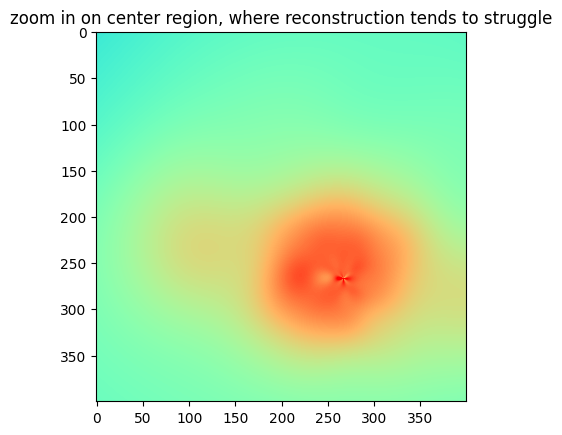

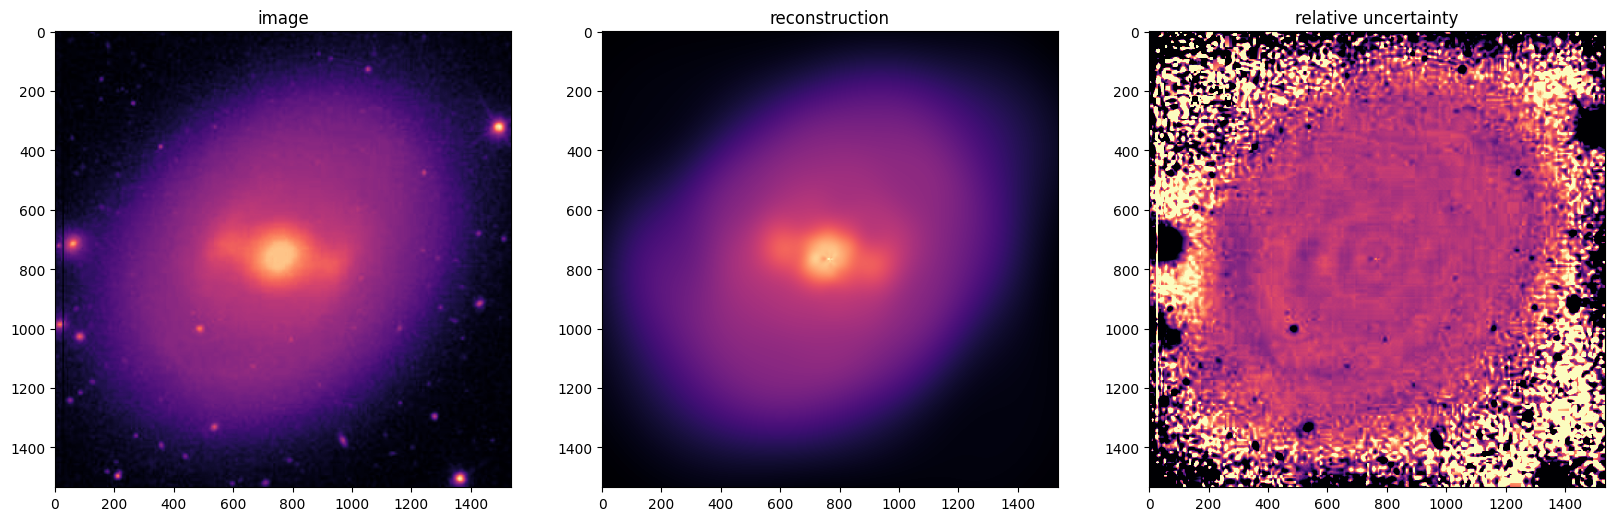

In [25]:
s = 5 #we want to size this image up by a factor of five
bar = resize_local_mean(barf, (int(s*barf.shape[0]),int(s*barf.shape[0])))

xp = np.linspace(-bar.shape[0]/2.,bar.shape[0]/2.,bar.shape[0]) #getting x, y array
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix) #transforming to r, phi
    
    
rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
barflat = bar.reshape(-1,).copy() #need a copy

# pick a radius of the image where we ignore everything outside of that radius
gvals = np.where(rval>200*s)
    
rval[gvals]         = np.nan
phi[gvals]          = np.nan
print(bar.shape, bar.max())
barflat[gvals] = np.nan
    
print(bar.shape, bar.max())
# pick orders for the expansion
mmax = 8  
nmax = 12 #twelve makes the mapping to notes easier
    
# pick a scalelength for the reconstruction
rscl = 15.*s #scale scalelength by the image rescaling factor

# make the expansion and compute the weights
# input into LaguerreAmplitudes is rscl, mmax, nmax, R, phi, mass=1., velocity=1.
LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,barflat) #this computes everything
c_bar, s_bar = LG.laguerre_amplitudes_returns() #this returns the cosine and sine amplitudes
      
LG.laguerre_reconstruction(rr,pp) #reconstructing the image using the BEF, computing the brightness at each r, phi in the image

#plots!
plt.figure()
plt.title('zoom in on center region, where reconstruction tends to struggle')
plt.imshow((LG.reconstruction)[100*s:180*s,100*s:180*s],vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap='rainbow')


# make a figure for the comparison of real to reconstruction
fig = plt.figure(figsize=(20,10),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow((bar), cmap=plt.cm.magma)
ax2.imshow((LG.reconstruction),vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap=cm.magma)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.imshow((LG.reconstruction-bar)/bar,vmin=-.25,vmax=.25,cmap=cm.magma)

ax1.set_title('image')
ax2.set_title('reconstruction')
ax3.set_title('relative uncertainty')


#### rinse and repeat for our spiral -

(1595, 1595) 0.8644536652835408
(1595, 1595) 0.8644536652835408
returning coscoefs, sincoefs


/var/folders/l4/60k630dd5bj2p5fwtj1gg3zc0000gn/T/ipykernel_62771/2781379450.py:50: RuntimeWarning: divide by zero encountered in divide
  ax3.imshow((LG.reconstruction-spiral)/spiral,vmin=-.25,vmax=.25,cmap=cm.magma)


Text(0.5, 1.0, 'relative uncertainty')

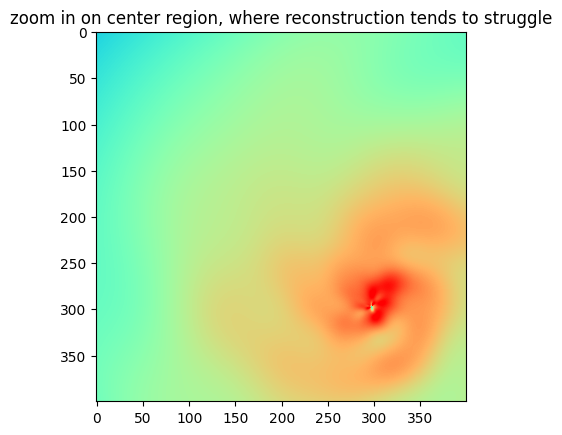

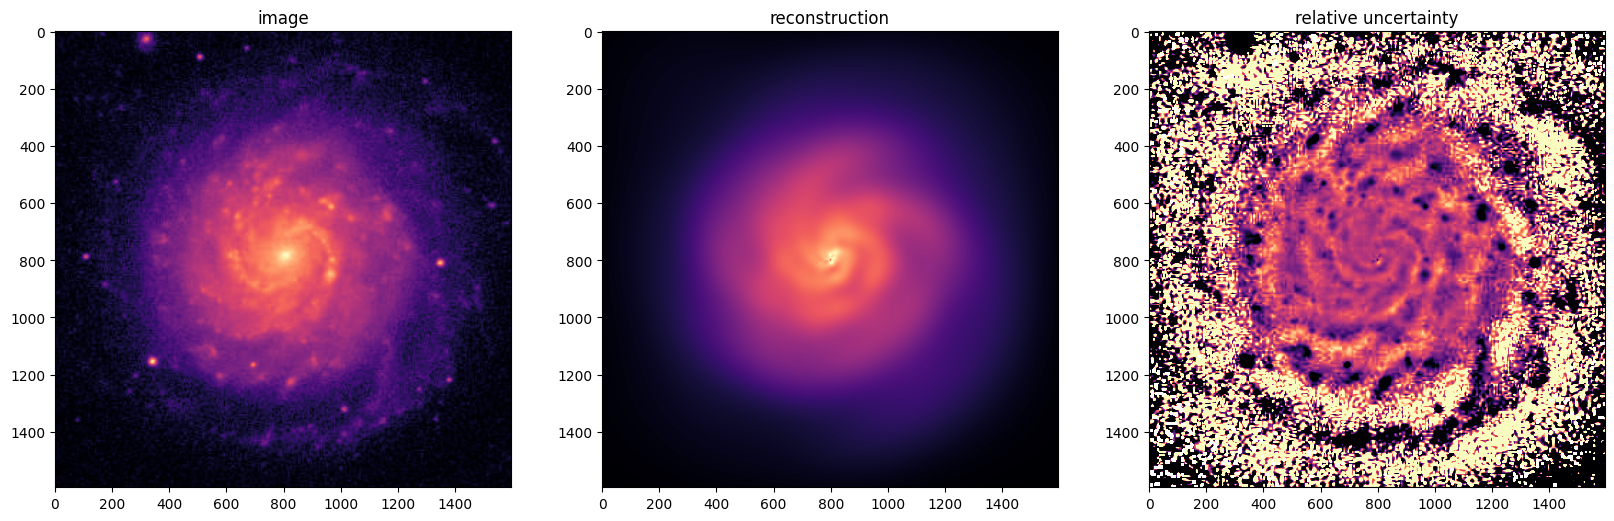

In [26]:
s = 5
spiral = resize_local_mean(spiralf, (int(s*spiralf.shape[0]),int(s*spiralf.shape[0])))

xp = np.linspace(-spiral.shape[0]/2.,spiral.shape[0]/2.,spiral.shape[0])
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix)
    
    
rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
spiralflat = spiral.reshape(-1,).copy() #need a copy

# pick a radius to not consider outside of
gvals = np.where(rval>210*s)
    
rval[gvals]         = np.nan
phi[gvals]          = np.nan
print(spiral.shape, spiral.max())
spiralflat[gvals] = np.nan
    
print(spiral.shape, spiral.max())
# pick orders for the expansion
mmax = 8
nmax = 12 
    
# pick a scalelength for the reconstruction
rscl = 10.*s #smaller here!!
    
# make the expansion and compute the weights
LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,spiralflat)
c_spiral, s_spiral = LG.laguerre_amplitudes_returns()
    
    
LG.laguerre_reconstruction(rr,pp)
plt.figure()
plt.title('zoom in on center region, where reconstruction tends to struggle')
plt.imshow((LG.reconstruction)[100*s:180*s,100*s:180*s],vmin=np.nanmin(spiral), vmax=np.nanmax(spiral),cmap='rainbow')
    
# make a figure for the comparison
fig = plt.figure(figsize=(20,10),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow((spiral), cmap=plt.cm.magma)
ax2.imshow((LG.reconstruction),vmin=np.nanmin(spiral), vmax=np.nanmax(spiral),cmap=cm.magma)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.imshow((LG.reconstruction-spiral)/spiral,vmin=-.25,vmax=.25,cmap=cm.magma)

ax1.set_title('image')
ax2.set_title('reconstruction')
ax3.set_title('relative uncertainty')

# moving on to sounds!

In [27]:
#getting min/max bounds- helpful for future plots
def find_vmin_vmax(min, max):
    if abs(min) < abs(max):
        min = -abs(max)
    elif abs(min)>abs(max):
        max = abs(min)
    return min, max

Text(0, 0.5, 'n')

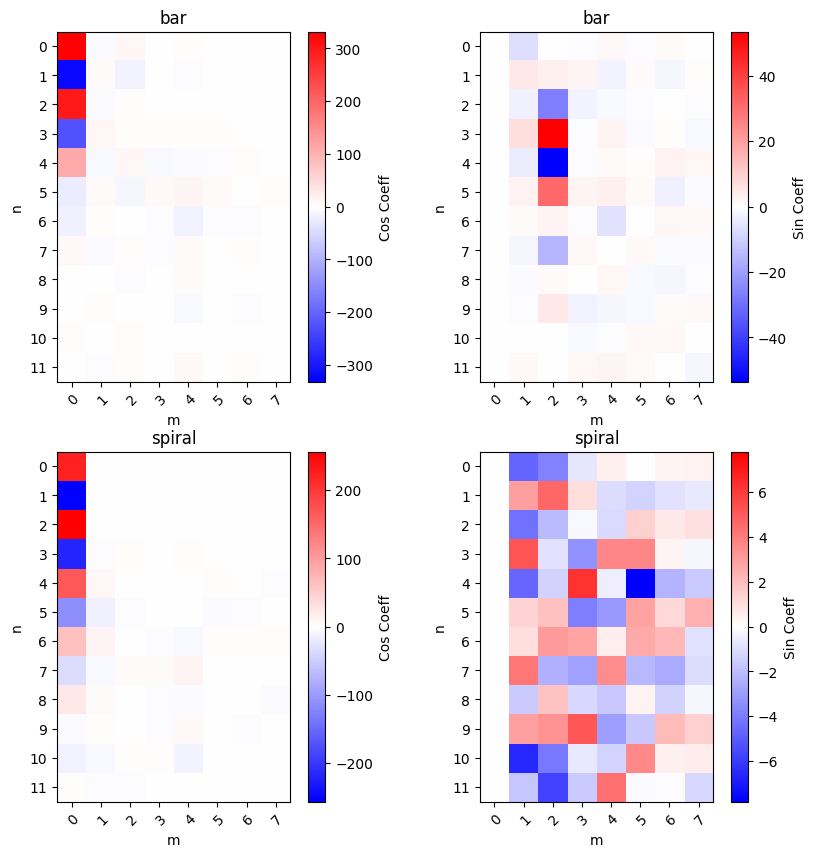

In [28]:
min_max_bar_c = (c_bar.copy()).flatten()
min_max_spiral_c = (c_spiral.copy()).flatten()
min_max_bar_s = (s_bar.copy()).flatten()
min_max_spiral_s = (s_spiral.copy()).flatten()
#getting minimum, maximums for coefficients (helpful in setting color range)
min_b_s, max_b_s = np.min(min_max_bar_s), np.max(min_max_bar_s)
min_b_c, max_b_c = np.min(min_max_bar_c), np.max(min_max_bar_c)

vmin_bar_c, vmax_bar_c = find_vmin_vmax(min_b_c, max_b_c)
vmin_bar_s, vmax_bar_s = find_vmin_vmax(min_b_s, max_b_s)

#plotting heat map of the coefficients 
fig, (ax1, ax2) = plt.subplots(2,2,figsize=(10,10))
ax1[0].set_title('bar')
im = ax1[0].imshow(c_bar.T,cmap='bwr',vmin=vmin_bar_c, vmax=vmax_bar_c)
fig.colorbar(im, ax=ax1[0], label='Cos Coeff')
# Show all ticks and label them with the respective list entries
ax1[0].set_xticks(np.arange(mmax), labels=np.arange(mmax))
ax1[0].set_yticks(np.arange(nmax), labels=np.arange(nmax))

# Rotate the tick labels and set their alignment.
plt.setp(ax1[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax1[0].set_xlabel('m')
ax1[0].set_ylabel('n')

ax1[1].set_title('bar')
im = ax1[1].imshow(s_bar.T,cmap='bwr',vmin=vmin_bar_s, vmax=vmax_bar_s)
fig.colorbar(im, ax=ax1[1], label='Sin Coeff')
# Show all ticks and label them with the respective list entries
ax1[1].set_xticks(np.arange(mmax), labels=np.arange(mmax))
ax1[1].set_yticks(np.arange(nmax), labels=np.arange(nmax))

# Rotate the tick labels and set their alignment.
plt.setp(ax1[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax1[1].set_xlabel('m')
ax1[1].set_ylabel('n')


min_s_s, max_s_s = np.min(min_max_spiral_s), np.max(min_max_spiral_s)
min_s_c, max_s_c = np.min(min_max_spiral_c), np.max(min_max_spiral_c)

vmin_spiral_c, vmax_spiral_c = find_vmin_vmax(min_s_c, max_s_c)
vmin_spiral_s, vmax_spiral_s = find_vmin_vmax(min_s_s, max_s_s)

ax2[0].set_title('spiral')
im = ax2[0].imshow(c_spiral.T,cmap='bwr',vmin=vmin_spiral_c, vmax=vmax_spiral_c)
fig.colorbar(im, ax=ax2[0], label='Cos Coeff')
# Show all ticks and label them with the respective list entries
ax2[0].set_xticks(np.arange(mmax), labels=np.arange(mmax))
ax2[0].set_yticks(np.arange(nmax), labels=np.arange(nmax))

# Rotate the tick labels and set their alignment.
plt.setp(ax2[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax2[0].set_xlabel('m')
ax2[0].set_ylabel('n')

ax2[1].set_title('spiral')
im = ax2[1].imshow(s_spiral.T,cmap='bwr',vmin=vmin_spiral_s, vmax=vmax_spiral_s)
fig.colorbar(im, ax=ax2[1], label='Sin Coeff')
# Show all ticks and label them with the respective list entries
ax2[1].set_xticks(np.arange(mmax), labels=np.arange(mmax))
ax2[1].set_yticks(np.arange(nmax), labels=np.arange(nmax))

# Rotate the tick labels and set their alignment.
plt.setp(ax2[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax2[1].set_xlabel('m')
ax2[1].set_ylabel('n')

## how we'll do our mapping - m's map to octaves, n's map to notes:

Text(0, 0.5, 'notes - ns')

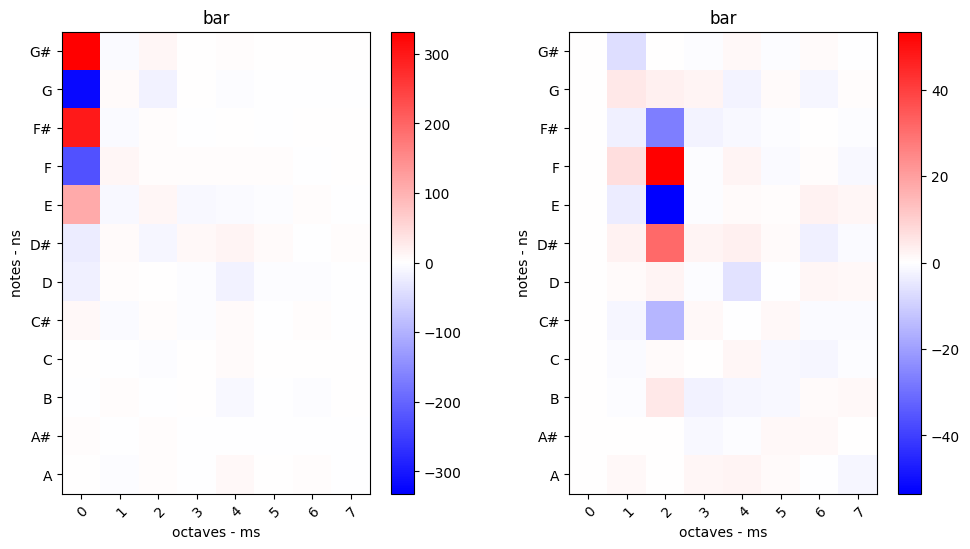

In [48]:
#list of unique notes, sorted lowest frequency to highest frequency
note_list = np.sort(np.array(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']))[::-1]

fig, (ax1) = plt.subplots(1,2,figsize=(12,6))

ax1[0].set_title('bar')
im = ax1[0].imshow(c_bar.T,cmap='bwr',vmin=vmin_bar_c, vmax=vmax_bar_c)
fig.colorbar(im, ax=ax1[0])
# Show all ticks and label them with the respective list entries
ax1[0].set_xticks(np.arange(mmax), labels=np.arange(mmax))
ax1[0].set_yticks(np.arange(nmax), labels=note_list)

# Rotate the tick labels and set their alignment.
plt.setp(ax1[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax1[0].set_xlabel('octaves - ms')
ax1[0].set_ylabel('notes - ns')

ax1[1].set_title('bar')
im = ax1[1].imshow(s_bar.T,cmap='bwr',vmin=vmin_bar_s, vmax=vmax_bar_s)
fig.colorbar(im, ax=ax1[1])
# Show all ticks and label them with the respective list entries
ax1[1].set_xticks(np.arange(mmax), labels=np.arange(mmax))
ax1[1].set_yticks(np.arange(nmax), labels=note_list)
# Rotate the tick labels and set their alignment.
plt.setp(ax1[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax1[1].set_xlabel('octaves - ms')
ax1[1].set_ylabel('notes - ns')

# doing the mapping:

In [30]:
#what is the highest amplitude coeefficient (looking at both sin and cos)
abs_max = np.max(np.array([np.max(abs(min_max_bar_c)),np.max(abs(min_max_bar_s))]))

c_bar_copy = c_bar.copy()
s_bar_copy = s_bar.copy()
note_cos = NoteContainer()
note_sin = NoteContainer()
note_tote = NoteContainer()
for m in range(mmax):
    octave = m
    for n in range(nmax):
        amp_c = c_bar_copy[m,n]
        amp_s = s_bar_copy[m,n]
        if abs(amp_c) >= .025*abs_max: #if the amplitude of this coefficient is at least 2.5% the maximum, we will make it audible
            if amp_c > 0: #if the amplitude is positive, use channel one so we can use different instruments for positive and negative coeffs
                noteys = Note(note_list[n],octave=octave,channel=1)
                note_cos.add_notes(noteys)
                note_tote.add_notes(noteys)
            else: #if the amplitude is negative, use channel two
                noteys = Note(note_list[n],octave=octave,channel=2)
                note_cos.add_notes(noteys)
                note_tote.add_notes(noteys)
        
        if abs(amp_s) >= .025*abs_max: #repeat for sin
            if amp_s > 0:
                noteys = Note(note_list[n],octave=octave,channel=1)
                note_sin.add_notes(noteys)
                note_tote.add_notes(noteys)
            else:
                noteys = Note(note_list[n],octave=octave,channel=2)
                note_sin.add_notes(noteys)
                note_tote.add_notes(noteys)


In [31]:
#rinse + repeat for spiral
abs_max = np.max(np.array([np.max(abs(min_max_spiral_c)),np.max(abs(min_max_spiral_s))]))

c_spiral_copy = c_spiral.copy()
s_spiral_copy = s_spiral.copy()
note_cos_spiral = NoteContainer()
note_sin_spiral = NoteContainer()
note_tote_spiral = NoteContainer()
for m in range(mmax):
    octave = m
    for n in range(nmax):
        amp_c = c_spiral_copy[m,n]
        amp_s = s_spiral_copy[m,n]
        if abs(amp_c) >= .025*abs_max: 
            if amp_c > 0:
                noteys = Note(note_list[n],octave=octave,channel=1)
                note_cos_spiral.add_notes(noteys)
                note_tote_spiral.add_notes(noteys)
            else:
                noteys = Note(note_list[n],octave=octave,channel=2)
                note_cos_spiral.add_notes(noteys)
                note_tote_spiral.add_notes(noteys)
        
        if abs(amp_s) >= .025*abs_max: 
            if amp_s > 0:
                noteys = Note(note_list[n],octave=octave,channel=1)
                note_sin_spiral.add_notes(noteys)
                note_tote_spiral.add_notes(noteys)
            else:
                noteys = Note(note_list[n],octave=octave,channel=2)
                note_sin_spiral.add_notes(noteys)
                note_tote_spiral.add_notes(noteys)

the list of which instruments correspond to what number in MIDI is here:

https://en.wikipedia.org/wiki/General_MIDI

After some experimentation, I picked piano and string ensemble

In [46]:
fluidsynth.set_instrument(1,1) #put piano on channel 1 - positive notes will be piano
fluidsynth.set_instrument(2,49) #put string ensemble on channel 2 - negative notes will be strings

#play the sounds for bar!
fluidsynth.play_NoteContainer(note_tote, channel=[note.channel for note in note_tote])
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(note_tote))


True

In [47]:
#play the sounds for spiral!
fluidsynth.play_NoteContainer(note_tote_spiral,channel=[note.channel for note in note_tote_spiral])
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(note_tote_spiral),channel=[note.channel for note in note_tote_spiral])

True

# trying to layer the sounds over time (work in progress....)

In [42]:
fluidsynth.set_instrument(1,1) 
fluidsynth.set_instrument(2,49) 
for i in note_tote:
    fluidsynth.play_Note(i, channel=i.channel)
    time.sleep(.05)
time.sleep(2)
fluidsynth.stop_everything()

In [43]:
fluidsynth.set_instrument(1,1) 
fluidsynth.set_instrument(2,49) 
for i in note_tote_spiral:
    fluidsynth.play_Note(i, channel=i.channel)
    time.sleep(.05)
time.sleep(2)
fluidsynth.stop_everything()

## To do:
- figure out what is going on with the reconstruction (can we get rid of the artefacts in the center?)

- look at different mapping choices (instruments, what maps to what ((like do we want to map coefficient amplitude to volume? what do we do if we want to have n > 12?)), ordering of notes in the mapping....)

- advance to 3D!
   * Consider both star particles and dark matter - ask fun questions like what does a bar forming sound like in baryonic and in dark matter There will be more choices to make here on how to do the mapping
   * How do we condense the dimensions further to make it easier to hear differences?

In [20]:
#saving out
#I haven't figured out how to save out the channel information yet - this only saves the piano :(
from mingus.midi import midi_file_out
midi_file_out.write_NoteContainer("sound_a.mid", note_tote_spiral, bpm=10)
midi_file_out.write_NoteContainer("sound_b.mid", note_tote,bpm=10)

True

# if anyone asks why I rescale the image...

(307, 307) 1.0
(307, 307) 1.0
returning coscoefs, sincoefs


Text(0.5, 1.0, 'relative uncertainty')

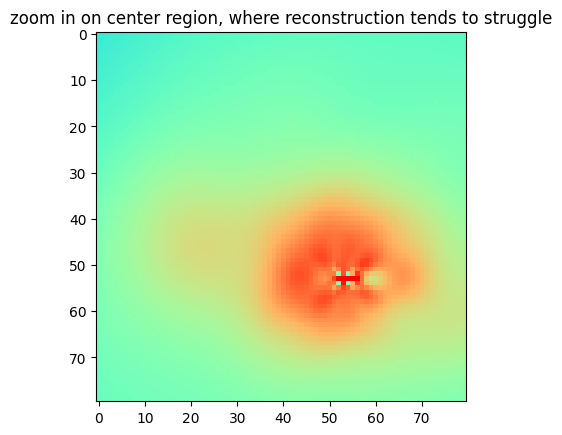

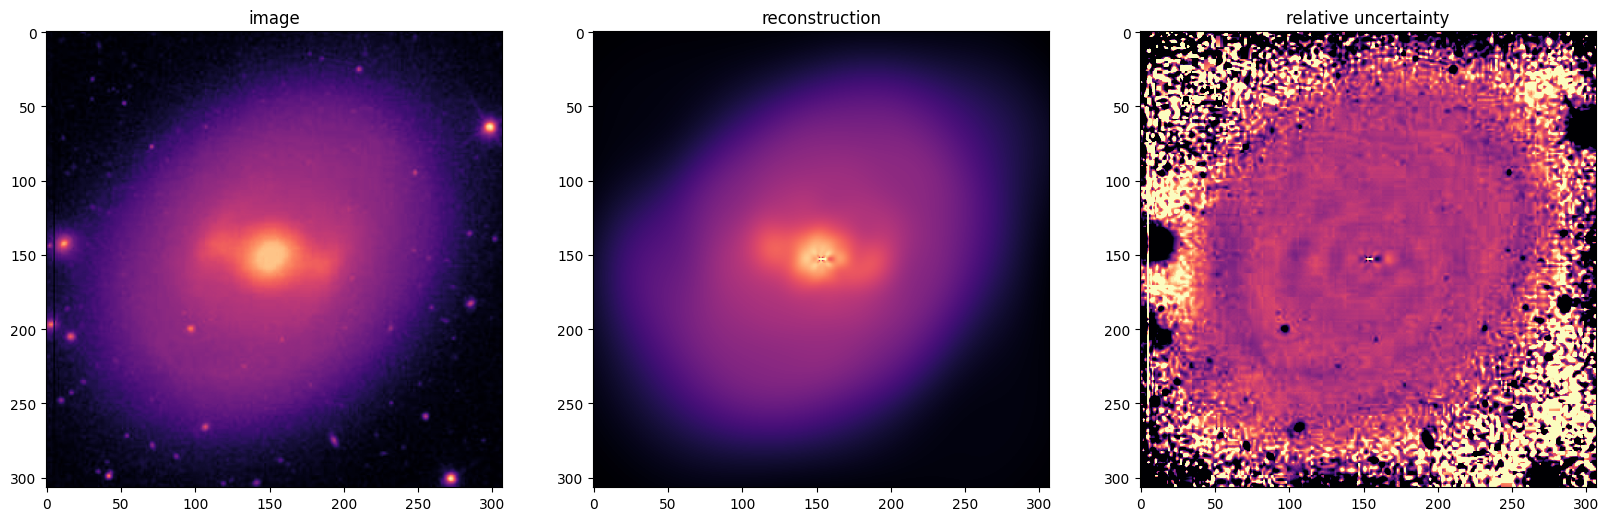

In [49]:
s = 1 #we want to size this image up by a factor of five
bar = resize_local_mean(barf, (int(s*barf.shape[0]),int(s*barf.shape[0])))

xp = np.linspace(-bar.shape[0]/2.,bar.shape[0]/2.,bar.shape[0]) #getting x, y array
xpix,ypix = np.meshgrid(xp,xp)
rr,pp = np.sqrt(xpix**2+ypix**2),np.arctan2(ypix,xpix) #transforming to r, phi
    
    
rval = np.sqrt(xpix**2+ypix**2).reshape(-1,)
phi  = np.arctan2(ypix,xpix).reshape(-1,)
barflat = bar.reshape(-1,).copy() #need a copy

# pick a radius of the image where we ignore everything outside of that radius
gvals = np.where(rval>200*s)
    
rval[gvals]         = np.nan
phi[gvals]          = np.nan
print(bar.shape, bar.max())
barflat[gvals] = np.nan
    
print(bar.shape, bar.max())
# pick orders for the expansion
mmax = 8  
nmax = 12 #twelve makes the mapping to notes easier
    
# pick a scalelength for the reconstruction
rscl = 15.*s #scale scalelength by the image rescaling factor

# make the expansion and compute the weights
# input into LaguerreAmplitudes is rscl, mmax, nmax, R, phi, mass=1., velocity=1.
LG = LaguerreAmplitudes(rscl,mmax,nmax,rval,phi,barflat) #this computes everything
c_bar, s_bar = LG.laguerre_amplitudes_returns() #this returns the cosine and sine amplitudes
      
LG.laguerre_reconstruction(rr,pp) #reconstructing the image using the BEF, computing the brightness at each r, phi in the image

#plots!
plt.figure()
plt.title('zoom in on center region, where reconstruction tends to struggle')
plt.imshow((LG.reconstruction)[100*s:180*s,100*s:180*s],vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap='rainbow')


# make a figure for the comparison of real to reconstruction
fig = plt.figure(figsize=(20,10),facecolor='white')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cval = np.linspace(-5.,1.,32)
ax1.imshow((bar), cmap=plt.cm.magma)
ax2.imshow((LG.reconstruction),vmin=np.nanmin(bar), vmax=np.nanmax(bar),cmap=cm.magma)

# plot the relative uncertainty (maxed out at 25 percent)
ax3.imshow((LG.reconstruction-bar)/bar,vmin=-.25,vmax=.25,cmap=cm.magma)

ax1.set_title('image')
ax2.set_title('reconstruction')
ax3.set_title('relative uncertainty')